<a href="https://colab.research.google.com/github/kregier/AudioLanguageClassifer/blob/main/GenderClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Identify the gender of the speaker from an audio file.

Split data into train and test sets
For **all** audio files, segment into 10s segments.
For **training** data, copy segments and add random noise.

Load the VGGish model.

Create dataset generators to process the files in batches. The data generator runs the segments through the VGGish model and extract the feature embeddings, which are used as input to the classifier model.




In [1]:
# Set up the environment
#!pip install pyAudioAnalysis
#!pip install hmmlearn
#!pip install eyed3
#!pip install pydub
!pip install soundfile

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import IPython.display as ipd
import librosa
#import librosa.display
import soundfile as sf

#from pyAudioAnalysis import audioSegmentation as aS

import os
import random
import re

import tensorflow as tf
import tensorflow_hub as hub

from keras.layers import Dense
from keras.models import Sequential

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

print("All set up!")

All set up!


In [2]:
# Set up the data import using Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

# Change working directory
%cd /content/gdrive/My Drive/Kaggle
!ls

/content/gdrive/My Drive/Kaggle
augment  kaggle.json	reading-passage.txt  speakers_all.csv
data	 processed.csv	recordings


In [4]:
# Import custom functions that I wrote
import augment
from augment import Augment

from imp import reload
#reload(augment)
#reload(augment.Augment)

Module imported
Augment scripts reloaded


In [5]:
# Set constants
SAMP_RATE = 16000  #Defined in augment package
BATCH_SIZE = 32  #Defined in augment package
CLF = 'gender'

In [6]:
meta = pd.read_csv('processed.csv', index_col='speakerid')
meta.head()

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
1,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,south africa,False
2,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,south africa,False
3,25.0,15.0,"diekabo, ivory coast",agni1,agni,male,ivory coast,False
4,19.0,6.0,"prishtina, kosovo",albanian1,albanian,male,kosovo,False
5,33.0,15.0,"tirana, albania",albanian2,albanian,male,albania,False


In [7]:
meta.shape

(2134, 8)

In [8]:
meta.isnull().sum()

age                0
age_onset          0
birthplace         0
filename           0
native_language    0
sex                0
country            0
file_missing?      0
dtype: int64

# Data processing
## Split into training and testing sets

In [9]:
# Split data into training and testing sets for gender analysis
data = meta[['filename','sex']]
x_train_names, x_test_names, y_train, y_test = train_test_split(
    data['filename'], data['sex'], test_size=0.25, random_state=38, 
    stratify=data['sex'])

In [10]:
print("Number of training files: ", x_train_names.shape)
print("Number of testing files: ", x_test_names.shape)

Number of training files:  (1600,)
Number of testing files:  (534,)


## Segment the audio files into 10s segments
This takes a bit of time, but should only need to be done once.

In [11]:
# Check if training data has been segmented. If not, segment each audio file.
train_file_list = os.listdir('data/gender/train')

for i in range(len(x_train_names)):
  # get a filename
  filename = x_train_names.iloc[i]
  # Check to see if the filename has already been segmented
  # if any(file.startswith(filename) for file in os.listdir('data/gender/train')):
  if any(file.startswith(filename) for file in train_file_list):
    pass
  else: 
    augment.Augment.segment_audio(x_train_names.iloc[i], y_train.iloc[i], split='train', clf=CLF)
    print('{} segmented'.format(filename))

In [12]:
# Check if testing data has been segmented. If not, segment each audio file.
test_file_list = os.listdir('data/gender/test')
for i in range(len(x_test_names)):
  filename = x_test_names.iloc[i]
  # if any(file.startswith(filename) for file in os.listdir('data/gender/test')):
  if any(file.startswith(filename) for file in test_file_list):
    pass
  else: 
    augment.Augment.segment_audio(x_test_names.iloc[i], y_test.iloc[i], split='test', clf=CLF)
    print('{} segmented'.format(filename))

In [13]:
# Generate a list training filenames + segment index to input to add_noise() function
x_train_seg = [x.split('o.wav')[0] for x in os.listdir('data/gender/train') if x.endswith('o.wav')]
print(len(x_train_seg))

3460


In [14]:
print(x_train_seg[:BATCH_SIZE])

['russian31.M.0', 'portuguese34.M.0', 'portuguese34.M.1', 'danish3.F.0', 'taiwanese7.F.0', 'taiwanese7.F.1', 'taiwanese7.F.2', 'taiwanese7.F.3', 'swedish17.F.0', 'swedish17.F.1', 'spanish62.F.0', 'spanish62.F.1', 'spanish62.F.2', 'ngemba1.M.0', 'ngemba1.M.1', 'ngemba1.M.2', 'romanian4.F.0', 'romanian4.F.1', 'arabic23.M.0', 'arabic23.M.1', 'bengali13.F.0', 'bengali13.F.1', 'hungarian6.F.0', 'hungarian6.F.1', 'hungarian6.F.2', 'spanish122.F.0', 'spanish122.F.1', 'russian24.F.0', 'russian24.F.1', 'russian24.F.2', 'korean25.F.0', 'korean25.F.1']


In [15]:
# Generate a list testing filenames + segment index
x_test_seg = [x.split('o.wav')[0] for x in os.listdir('data/gender/test') if x.endswith('o.wav')]
print(len(x_test_seg))

1206


## Add noise to segments in training set
Not necesary for testing set

In [16]:
# Check if training data has been augmented with noise. If not, add noise to each segment.
noise_train_list = os.listdir('data/gender/train')
for i in range(len(x_train_seg)):
  filename = x_train_seg[i]
  # if any((file.startswith(filename)& file.endswith('n.wav')) for file in os.listdir('data/gender/train')):
  if any((file.startswith(filename)& file.endswith('n.wav')) for file in noise_train_list):
    pass
  else: 
    augment.Augment.noisy_data(x_train_seg[i], split='train', clf=CLF)
    print('{} augmented'.format(filename))

In [17]:
# Verify there are equal numbers for original segments and noisy segments.
x_train_noise = [x.split('n.wav')[0] for x in os.listdir('data/gender/train') if x.endswith('n.wav')]
print(len(x_train_seg) == len(x_train_noise))

True


## Format input lists for generator

In [18]:
x_train_filenames = os.listdir('data/gender/train')
x_train_temp = [file for file in os.listdir('data/gender/train')if file.endswith('o.wav')]
print(x_train_filenames[:BATCH_SIZE])
print(x_train_temp[:BATCH_SIZE])

x_train_filepaths = ['data/gender/train/{}'.format(i) for i in x_train_filenames]
#print(x_train_filepaths[:5])
print(len(x_train_filepaths))

['english167.M.0n.wav', 'english167.M.1n.wav', 'english66.M.0n.wav', 'english66.M.1n.wav', 'hausa6.M.0n.wav', 'hausa6.M.1n.wav', 'susu1.M.0n.wav', 'susu1.M.1n.wav', 'german8.M.0n.wav', 'tamil6.F.0n.wav', 'tamil6.F.1n.wav', 'english171.M.0n.wav', 'czech5.F.0n.wav', 'czech5.F.1n.wav', 'czech5.F.2n.wav', 'portuguese5.M.0n.wav', 'portuguese5.M.1n.wav', 'portuguese5.M.2n.wav', 'english275.F.0n.wav', 'english275.F.1n.wav', 'english430.F.0n.wav', 'english430.F.1n.wav', 'english93.F.0n.wav', 'english93.F.1n.wav', 'bengali6.M.0n.wav', 'bengali6.M.1n.wav', 'mandarin62.M.0n.wav', 'mandarin62.M.1n.wav', 'turkish13.F.0n.wav', 'turkish13.F.1n.wav', 'english557.F.0n.wav', 'english326.M.0n.wav']
['russian31.M.0o.wav', 'portuguese34.M.0o.wav', 'portuguese34.M.1o.wav', 'danish3.F.0o.wav', 'taiwanese7.F.0o.wav', 'taiwanese7.F.1o.wav', 'taiwanese7.F.2o.wav', 'taiwanese7.F.3o.wav', 'swedish17.F.0o.wav', 'swedish17.F.1o.wav', 'spanish62.F.0o.wav', 'spanish62.F.1o.wav', 'spanish62.F.2o.wav', 'ngemba1.M.0o.wa

In [19]:
x_test_filenames = os.listdir('data/gender/test')
#print(x_test_filenames)

x_test_filepaths = ['data/gender/test/{}'.format(i) for i in x_test_filenames]
#print(x_test_filepaths[:5])
print(len(x_test_filepaths))

1206


## Load VGGish model
Generate a dataset to check the funtionality of the generator before applying to the larger dataset

In [20]:
# Using a SavedModel from the TFHub in Keras
# https://www.tensorflow.org/hub/tf2_saved_model
# VGGish model, from https://tfhub.dev/google/vggish/1

# Link to the model on TFHub
hub_url = 'https://tfhub.dev/google/vggish/1'

# Load the model as a Keras model
vggish_model = hub.KerasLayer(hub_url)
vggish_model.trainable = False

In [21]:
# Run one file through the model to get output shape
#import librosa
audio, sr = librosa.load(x_train_filepaths[0], SAMP_RATE)
sample = vggish_model(audio)
print(sample.shape)

(10, 128)


In [22]:
def tf_data_generator(file_list, batch_size=32):
    """ Create a dataset generator. 
    Iterate through a list of filenames and process in batches.
    Extract audio features from vggish model.
    WARNING: This generator forms an infinite loop, 
    so you need to specify how long to run the generator 
    before fitting and evaluating a model.

    Arguments:
    file_list - list of filenames to iterate
    vggish_model  - pass the instantiated model to the function
    batch_size - how many files to process at a time
    """
    i = 0
    while True: #infinite loop
        if i*batch_size >= len(file_list):
            i=0
            np.random.shuffle(file_list)
        else:
            file_chunk = file_list[i*batch_size:(i+1)*batch_size]
            data = []
            labels = []
            label_classes = tf.constant(['M', 'F'])
            for file in file_chunk:
                # Read data
                audio, sr = librosa.load(file, sr=16000)
                # Apply transformations
                embed = vggish_model(audio)
                data.append(embed)
                # Extract labels from filename
                bytes_string = file
                string_name = str(bytes_string, 'utf-8')
                split_str = string_name.split('.')
                #print(split_str)
                pattern = tf.constant(split_str[1])
                #print(pattern)
                for j in range(len(label_classes)):
                    if re.match(pattern.numpy(), label_classes[j].numpy()):
                        labels.append(j)

            data = np.asarray(data)
            labels = np.asarray(labels)

            yield data, labels
            i += 1

In [23]:
#reload(augment.TFGenerator)

In [24]:
x_train_filepaths[:2*BATCH_SIZE]

['data/gender/train/english167.M.0n.wav',
 'data/gender/train/english167.M.1n.wav',
 'data/gender/train/english66.M.0n.wav',
 'data/gender/train/english66.M.1n.wav',
 'data/gender/train/hausa6.M.0n.wav',
 'data/gender/train/hausa6.M.1n.wav',
 'data/gender/train/susu1.M.0n.wav',
 'data/gender/train/susu1.M.1n.wav',
 'data/gender/train/german8.M.0n.wav',
 'data/gender/train/tamil6.F.0n.wav',
 'data/gender/train/tamil6.F.1n.wav',
 'data/gender/train/english171.M.0n.wav',
 'data/gender/train/czech5.F.0n.wav',
 'data/gender/train/czech5.F.1n.wav',
 'data/gender/train/czech5.F.2n.wav',
 'data/gender/train/portuguese5.M.0n.wav',
 'data/gender/train/portuguese5.M.1n.wav',
 'data/gender/train/portuguese5.M.2n.wav',
 'data/gender/train/english275.F.0n.wav',
 'data/gender/train/english275.F.1n.wav',
 'data/gender/train/english430.F.0n.wav',
 'data/gender/train/english430.F.1n.wav',
 'data/gender/train/english93.F.0n.wav',
 'data/gender/train/english93.F.1n.wav',
 'data/gender/train/bengali6.M.0n.

In [25]:
#from augment.TFGenerator import tf_data_generator

dataset_check = tf.data.Dataset.from_generator(tf_data_generator,
                                         args = [x_train_filepaths[:2*BATCH_SIZE], BATCH_SIZE],
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes= ((None, 10, 128),(None,)) )

In [26]:
for data, labels in dataset_check.take(2):
  print(data.shape)
  print(labels)

(32, 10, 128)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 0.], shape=(32,), dtype=float32)
(32, 10, 128)
tf.Tensor(
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 1.], shape=(32,), dtype=float32)


## Generate training, validation and testing datasets

In [27]:
x_train, x_val = train_test_split(x_train_filepaths, test_size=.25, random_state=38)

In [28]:
# Print sizes of data splits
print("Number of training samples: ", len(x_train))
print("Number of validation samples: ", len(x_val))
print("Number of testing samples: ", len(x_test_seg))

Number of training samples:  5190
Number of validation samples:  1730
Number of testing samples:  1206


In [29]:
train_dataset = tf.data.Dataset.from_generator(tf_data_generator, 
                                         args = [x_train, BATCH_SIZE],
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes= ((None, 10, 128),(None,)) ) 
validation_dataset = tf.data.Dataset.from_generator(tf_data_generator, 
                                         args = [x_val, BATCH_SIZE],
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes= ((None, 10, 128),(None,)) )
test_dataset = tf.data.Dataset.from_generator(tf_data_generator, 
                                         args = [x_test_filepaths, BATCH_SIZE],
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes= ((None, 10, 128),(None,)) ) 

# Build and compile the classifier model

In [30]:
genderClf = tf.keras.models.Sequential([tf.keras.layers.Dense(128, activation = 'relu', input_shape=(10, 128)),
                              tf.keras.layers.Dense(64, activation = 'relu'),
                              tf.keras.layers.Dense(1, activation='sigmoid'),
                              tf.keras.layers.AveragePooling1D(pool_size=10, strides=None, padding="valid", data_format="channels_last")
                              ])
genderClf.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [31]:
# Add early stopping to train classifier model; default is 10 epochs
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)

In [ ]:
# Add model checkpoints, in case training times out on the GPU
ckpt_path = 'model/gender/cp.ckpt'
ckpt_dir = os.path.dirname(ckpt_path)

ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path,
    save_weights_only=True) #,
#    monitor='val_acc',
#    mode='max',
#    save_best_only=True)

**Important:**

Before fitting model, specify the number of epochs and stept to fit, to avoid infinite looping of the generators.

In [32]:
# Calculate how many dataset batches to generate, since generator is infinite
steps_per_epoch = np.int(np.ceil(len(x_train)/BATCH_SIZE))
val_steps = np.int(np.ceil(len(x_val)/BATCH_SIZE))
eval_steps = np.int(np.ceil(len(x_test_filepaths)/BATCH_SIZE))

print("steps_per_epoch = ", steps_per_epoch)
print("validation_steps = ", val_steps)
print("evaluation_steps = ", eval_steps)

steps_per_epoch =  163
validation_steps =  55
evaluation_steps =  38


In [33]:
for data, labels in train_dataset.take(2):
  print(data.shape)
  print(labels)

(32, 10, 128)
tf.Tensor(
[1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0.], shape=(32,), dtype=float32)
(32, 10, 128)
tf.Tensor(
[1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1.], shape=(32,), dtype=float32)


In [34]:
for data, labels in validation_dataset.take(2):
  print(data.shape)
  print(labels)

(32, 10, 128)
tf.Tensor(
[0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1.
 0. 1. 1. 0. 0. 1. 0. 1.], shape=(32,), dtype=float32)
(32, 10, 128)
tf.Tensor(
[0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1.
 0. 1. 1. 0. 1. 0. 1. 0.], shape=(32,), dtype=float32)


In [35]:
# Fit the classifier
history = genderClf.fit(train_dataset, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=5, 
                        validation_data=validation_dataset, 
                        validation_steps = val_steps,
                        callbacks=[early_stopping_monitor, ckpt], 
                        batch_size=BATCH_SIZE)

Epoch 1/5
163/163 [==============================] - 6278s 39s/step - loss: 0.1006 - accuracy: 0.9840 - val_loss: 0.0569 - val_accuracy: 0.9867
Epoch 2/5
163/163 [==============================] - 4430s 27s/step - loss: 0.0611 - accuracy: 0.9873 - val_loss: 0.0526 - val_accuracy: 0.9873
Epoch 3/5
163/163 [==============================] - 4462s 27s/step - loss: 0.0604 - accuracy: 0.9884 - val_loss: 0.0528 - val_accuracy: 0.9896
Epoch 4/5
163/163 [==============================] - 4452s 27s/step - loss: 0.0577 - accuracy: 0.9890 - val_loss: 0.0618 - val_accuracy: 0.9867


In [46]:
genderClf.save('genderClf1')

INFO:tensorflow:Assets written to: genderClf1/assets


INFO:tensorflow:Assets written to: genderClf1/assets


In [36]:
genderClf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10, 128)           16512     
_________________________________________________________________
dense_1 (Dense)              (None, 10, 64)            8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10, 1)             65        
_________________________________________________________________
average_pooling1d (AveragePo (None, 1, 1)              0         
Total params: 24,833
Trainable params: 24,833
Non-trainable params: 0
_________________________________________________________________


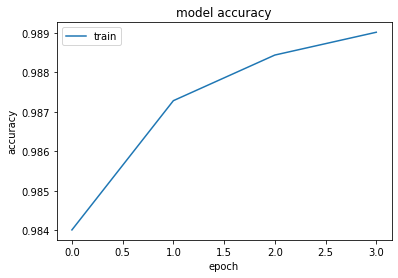

In [37]:
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

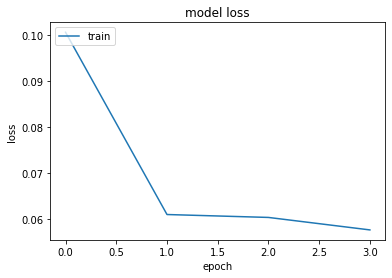

In [38]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluate the trained classifier

In [39]:
test_loss, test_acc = genderClf.evaluate(test_dataset, steps=eval_steps)

38/38 [==============================] - 1000s 26s/step - loss: 0.0898 - accuracy: 0.9751


In [40]:
y_pred = genderClf.predict(test_dataset, steps=eval_steps)

In [41]:
print(y_pred.shape)
# Probably need to reshape to format for classification report
#y_pred = y_pred [:, 0, 0]
#print(y_pred.shape)
#print(y_pred)

(1206, 1, 1)


In [44]:
gen_pred  = []
for i in y_pred:
  if i < 0.5:
    gen_pred.append(0)
  else: gen_pred.append(1)

print(gen_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 

In [49]:
# Get 1D array of labels from test_dataset
y_lab = np.concatenate([y for x, y in test_dataset.take[32]], axis=0)
print(len(y_lab))
print(y_lab[10])

TypeError: ignored

In [50]:
tf.math.confusion_matrix(y_lab, gen_pred)

NameError: ignored

In [ ]:
classification_report(y_lab, gen_pred)

In [ ]:
confusion_matrix(y_lab, gen_pred)

In [ ]:
# Load model weights from a previous checkpoint
# model.load_weights(checkpoint_filepath)

# Load model weights from the most recent checkpoint
# latest = tf.train.latest_checkpoint(ckpt_dir)
# model.load_weights(latest)

# Save the final model for future use

In [51]:
# Save the model using SavedModel format - default for tf2
genderClf.save('model/genderClassifier')

INFO:tensorflow:Assets written to: model/genderClassifier/assets


INFO:tensorflow:Assets written to: model/genderClassifier/assets


In [52]:
# Creates the directory 'model/gender/genderClassifier/'
!ls 'model/genderClassifier/'

INFO:tensorflow:Assets written to: model/genderClassifier/assets


INFO:tensorflow:Assets written to: model/genderClassifier/assets


assets	saved_model.pb	variables


In [ ]:
# Load the SavedModel
# new_model = tf.keras.model.load_model('model/gender/genderClassifier')
# new_model.summary()

In [ ]:
# Save the model - using HDFS
# genderClf.save('model/gender/genderClassifier.h5')

In [ ]:
# Load the saved model from HDFS
# new_model = tf.keras.model.load_model('model/gender/genderClassifier.h5')
# new_model.summary()